<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [25]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [26]:
WINDOW_SIZE = 5
X, y = df_to_X_y(df['% Silica Concentrate'], WINDOW_SIZE)
X.shape, y.shape

((3800, 5, 1), (3800,))

In [27]:
X_train, y_train = X[:2000], y[:2000]
X_val, y_val = X[2000:3500], y[2000:3500]
X_test, y_test = X[3500:], y[3500:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2000, 5, 1), (2000,), (1500, 5, 1), (1500,), (300, 5, 1), (300,))

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [51]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0025), metrics=[RootMeanSquaredError(), 'accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      epochs=50,
                      callbacks= [cp, early_stopping_monitor],
                      verbose=False)


In [53]:
from tensorflow.keras.models import load_model
model = load_model('model1/')

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})

val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'val Predictions':val_predictions, 'Actuals':y_val})

In [54]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

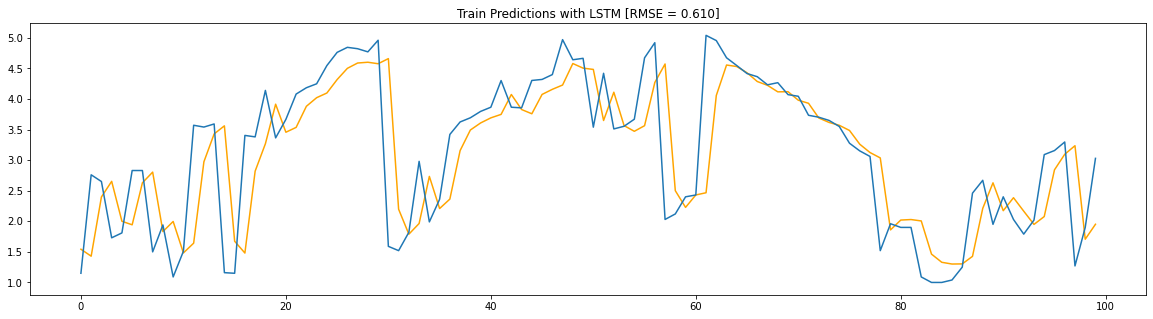

In [55]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(train_results['Train Predictions'], train_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(train_results['Train Predictions'][0:100], color='orange')
plt.plot(train_results['Actuals'][0:100])
plt.title("Train Predictions with LSTM [RMSE = %.3f]" % rmse)
plt.show()

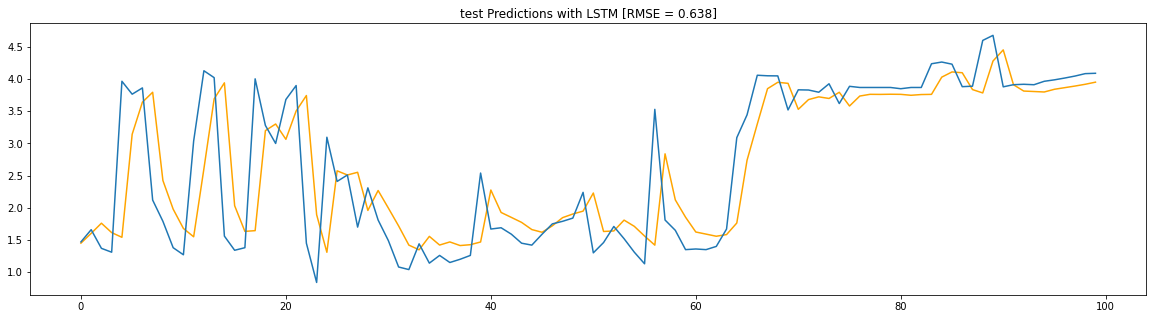

In [56]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(test_results['test Predictions'], test_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(test_results['test Predictions'][0:100], color='orange')
plt.plot(test_results['Actuals'][0:100])
plt.title("test Predictions with LSTM [RMSE = %.3f]" % rmse)
plt.show()

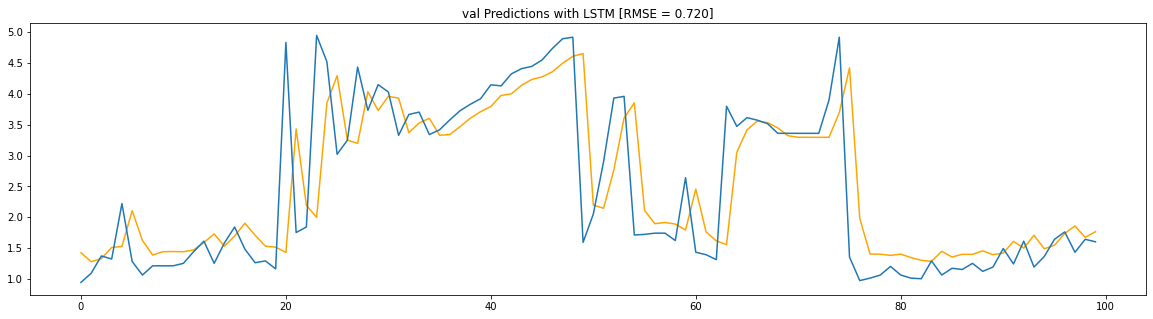

In [57]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(val_results['val Predictions'], val_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(val_results['val Predictions'][0:100], color='orange')
plt.plot(val_results['Actuals'][0:100])
plt.title("val Predictions with LSTM [RMSE = %.3f]" % rmse)
plt.show()

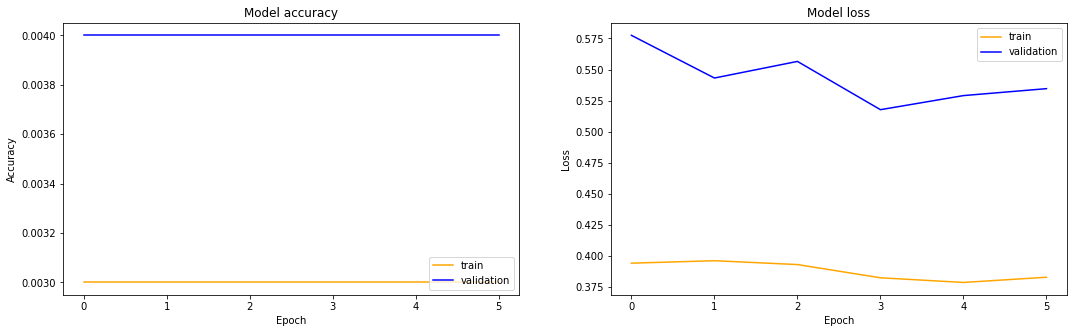

In [67]:
def plot_performance(model_history):
    # modle performance visualization
    # subplot
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    # accuracy
    ax1.plot(model_history.history['accuracy'], color='orange')
    ax1.plot(model_history.history['val_accuracy'], color='blue')
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    # "Loss"
    ax2.plot(model_history.history['loss'], color='orange')
    ax2.plot(model_history.history['val_loss'], color='blue')
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
plot_performance(history)